In [1]:
import pandas as pd
import os

# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

총 21,705,813개 레코드 병합 완료
유니크 사용자 수: 677,085

테이블별 레코드 수:
table_name
accounts_friendrequest_send              17147175
accounts_pointhistory                     2338918
accounts_userquestionrecord_processed     1217558
accounts_user_processed                    677085
polls_questionset                          158384
accounts_paymenthistory                     95140
polls_questionreport                        51424
accounts_blockrecord_processed              19449
event_receipts                                309
accounts_timelinereport                       208
accounts_failpaymenthistory                   163
Name: count, dtype: int64


In [1]:
import pandas as pd
import os

# 경로 설정
data_dir = '/home/jovyan/work/data'

# 포인트 이벤트 테이블
events = pd.read_csv(os.path.join(data_dir, 'events.csv'))

# 출석 테이블
accounts_attendance = pd.read_csv(os.path.join(data_dir, 'accounts_attendance.csv'))

# 친구 요청 테이블
accounts_friendrequest = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 학급 테이블
accounts_group = pd.read_csv(os.path.join(data_dir, 'accounts_group.csv'))

# 가까운 학교를 기록해두기 위한 관계형 테이블
accounts_nearbyschool = pd.read_csv(os.path.join(data_dir, 'accounts_nearbyschool.csv'))

# 유저 컨택 테이블
accounts_user_contacts = pd.read_csv(os.path.join(data_dir, 'accounts_user_contacts.csv'))

# 학교 테이블
accounts_school = pd.read_csv(os.path.join(data_dir, 'accounts_school.csv'))

# 포인트 이벤트 참여 테이블
accounts_userwithdraw = pd.read_csv(os.path.join(data_dir, 'accounts_userwithdraw.csv'))

# 질문 내용 테이블
polls_question = pd.read_csv(os.path.join(data_dir, 'polls_question.csv'))

# 질문에 대한 신고 기록 테이블
polls_questionpiece = pd.read_csv(os.path.join(data_dir, 'polls_questionpiece.csv'))

# 질문에 등장하는 유저들 테이블
polls_usercandidate = pd.read_csv(os.path.join(data_dir, 'polls_usercandidate.csv'))


가입 초기 친구 수가 많을수록 잔존 확률이 높다?

In [2]:
# 데이터 로딩 및 전처리
import pandas as pd
import os

# 경로 설정
data_dir = '/home/jovyan/work/data'

# 유저 정보 (잔존 여부 포함)
user_df = pd.read_csv(os.path.join(data_dir, 'accounts_user_processed.csv'))
user_df = user_df.rename(columns={'id': 'user_id'})

# 친구 요청 정보
friend_df = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))


: 

: 

: 

In [5]:
# 전체 친구 수 (보낸 요청 기준)
friend_count = friend_df.groupby('send_user_id').size().reset_index(name='friend_requests_sent')
friend_count = friend_count.rename(columns={'send_user_id': 'user_id'})

# 병합
user_df = user_df.merge(friend_count, on='user_id', how='left')
user_df['friend_requests_sent'] = user_df['friend_requests_sent'].fillna(0)

# 친구 수를 기준으로 범주형 변수 생성
def categorize_friend_count(x):
    if x == 0:
        return 'none'
    elif x <= 2:
        return 'few(1-2)'
    elif x <= 5:
        return 'some(3-5)'
    else:
        return 'many(6+)'

user_df['friend_count_category'] = user_df['friend_requests_sent'].apply(categorize_friend_count)


In [7]:
# 사용자별 생존기간 계산
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

print(f"사용자 생존기간 테이블 완성: {len(user_survival):,}명")
print(user_survival.head())

# 생존일 수 계산 (차이 in days)
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 유저 (당일 유저): 1, 잔존 유저: 0
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)

print(user_survival['is_churn'].value_counts())
# 1: 이탈 (하루만 활동), 0: 잔존

사용자 생존기간 테이블 완성: 677,085명
   user_id             first_activity              last_activity  total_events
0   831956 2023-03-29 03:44:14.047130 2023-03-29 03:44:14.047130             1
1   831962 2023-03-29 05:18:56.162368 2023-07-13 07:51:59.000000             2
2   832151 2023-03-29 12:56:34.989468 2023-05-09 15:50:58.000000            11
3   832340 2023-03-29 12:56:35.020790 2023-05-11 00:51:26.000000            29
4   832520 2023-03-29 12:56:35.049311 2023-03-29 12:56:35.049311             1
is_churn
0    441629
1    235456
Name: count, dtype: int64


In [8]:
# merged_df를 기반으로 최초 활동일과 최종 활동일의 차이를 24시간 단위로 계산해서 생성

user_df = user_df.merge(user_survival[['user_id', 'is_churn']], on='user_id', how='left')
user_df['retained'] = user_df['is_churn'].apply(lambda x: 0 if x == 1 else 1)

In [9]:
from scipy.stats import pointbiserialr

corr, pval = pointbiserialr(user_df['retained'], user_df['friend_requests_sent'])
print(f'[점이연 상관분석] 상관계수: {corr:.3f}, p-value: {pval:.5f}')


[점이연 상관분석] 상관계수: 0.256, p-value: 0.00000


In [10]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(user_df['friend_count_category'], user_df['retained'])
chi2, p, dof, expected = chi2_contingency(ct)

print('[카이제곱 검정]')
print(ct)
print(f'Chi2 통계량: {chi2:.3f}, p-value: {p:.5f}')


[카이제곱 검정]
retained                    0       1
friend_count_category                
few(1-2)                17652    7472
many(6+)               168006  415178
none                    27012    1001
some(3-5)               22786   17978
Chi2 통계량: 78061.443, p-value: 0.00000


In [11]:
import statsmodels.api as sm
import numpy as np

X = sm.add_constant(user_df['friend_requests_sent'])
y = user_df['retained']

model = sm.Logit(y, X).fit()
print(model.summary())

# 오즈비 출력
odds_ratio = np.exp(model.params['friend_requests_sent'])
print(f'Odds Ratio: {odds_ratio:.3f}')


Optimization terminated successfully.
         Current function value: 0.599167
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               retained   No. Observations:               677085
Model:                          Logit   Df Residuals:                   677083
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                 0.07256
Time:                        04:42:49   Log-Likelihood:            -4.0569e+05
converged:                       True   LL-Null:                   -4.3743e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2173      0.004    -49.812      0.000      -0.226      -0.209

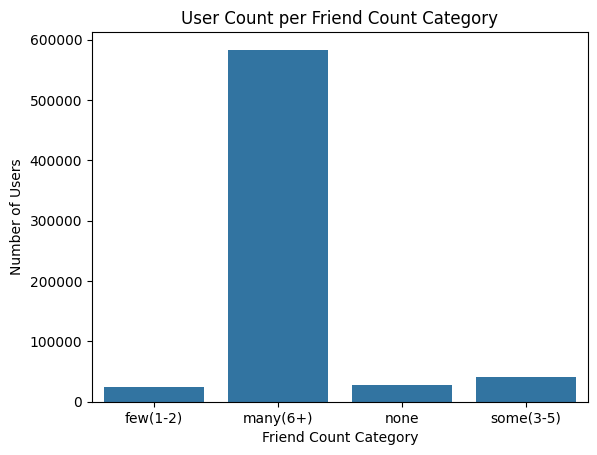

In [14]:
# 친구 수 0명 그룹 과대표집 확인용 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 친구 수 범주별 전체 유저 수 (빈도)
friend_cat_counts = user_df['friend_count_category'].value_counts().sort_index()

# 시각화
sns.barplot(x=friend_cat_counts.index, y=friend_cat_counts.values)
plt.title('User Count per Friend Count Category')  # 친구 수 범주별 유저 수
plt.xlabel('Friend Count Category')
plt.ylabel('Number of Users')
plt.show()


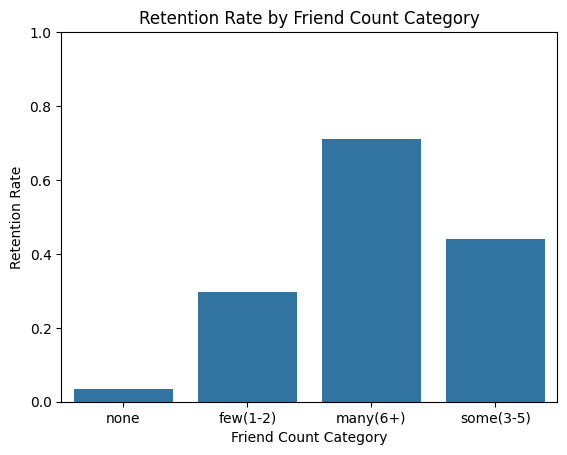

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create barplot for retention rate by friend count category
sns.barplot(data=user_df, x='friend_count_category', y='retained', errorbar=None)  # → ci=None 대신 errorbar=None
plt.title('Retention Rate by Friend Count Category')  # 친구 수 범주별 잔존율
plt.ylabel('Retention Rate')  # 잔존 비율
plt.xlabel('Friend Count Category')  # 친구 수 범주
plt.ylim(0, 1)  # 비율형 데이터 시각화 범위 설정

plt.show()


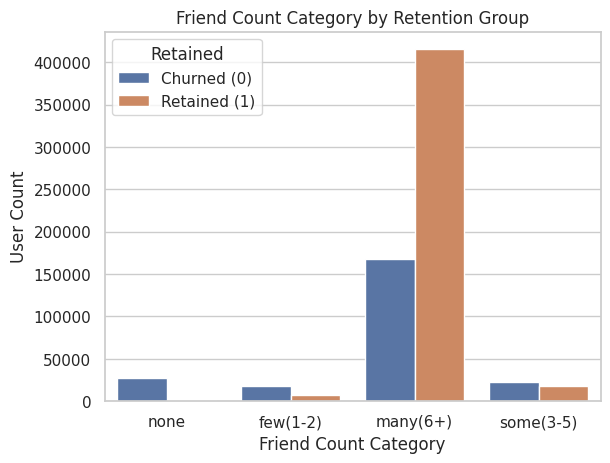

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style='whitegrid')

# Create grouped barplot
sns.countplot(data=user_df, x='friend_count_category', hue='retained')  # 잔존 여부에 따라 색 구분
plt.title('Friend Count Category by Retention Group')  # 잔존 그룹별 친구 수 범주 분포
plt.xlabel('Friend Count Category')  # 친구 수 범주
plt.ylabel('User Count')  # 유저 수
plt.legend(title='Retained', labels=['Churned (0)', 'Retained (1)'])  # 범례: 이탈 / 잔존
plt.show()


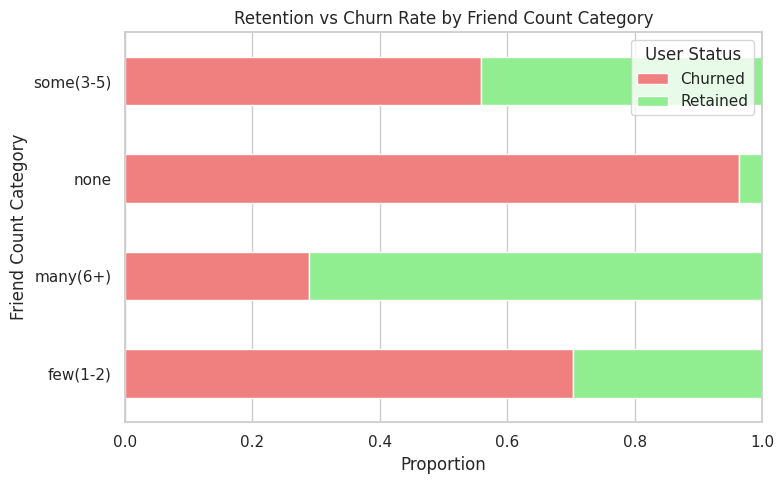

In [12]:
# 그룹별 count 계산 후 비율로 변환
count_df = user_df.groupby(['friend_count_category', 'retained']).size().unstack(fill_value=0)

# 비율 계산
prop_df = count_df.div(count_df.sum(axis=1), axis=0).reset_index()

# 컬럼명을 보기 좋게 정리
prop_df = prop_df.rename(columns={0: 'Churned', 1: 'Retained'})

import matplotlib.pyplot as plt

# 인덱스 설정 후 가로 막대그래프로 시각화
prop_df.set_index('friend_count_category')[['Churned', 'Retained']].plot(
    kind='barh',                     # 가로 막대 그래프
    stacked=True,                    # 스택 형태
    figsize=(8, 5),
    color=['#f08080', '#90ee90']     # 이탈: 연한 빨강, 잔존: 연한 초록
)

plt.title('Retention vs Churn Rate by Friend Count Category')  # 친구 수 범주별 잔존/이탈 비율
plt.xlabel('Proportion')   # x축: 비율
plt.ylabel('Friend Count Category')  # y축: 친구 수 범주
plt.xlim(0, 1)
plt.legend(title='User Status')
plt.tight_layout()
plt.show()



In [16]:
import psutil

def check_memory():
    """현재 메모리 사용량 확인"""
    mem = psutil.virtual_memory()
    used_gb = mem.used / (1024**3)
    total_gb = mem.total / (1024**3)
    percent = mem.percent
    
    print(f"💾 메모리: {used_gb:.1f}GB / {total_gb:.1f}GB ({percent:.1f}%)")
    
    if percent > 80:
        print("🔴 경고: 메모리 사용률 높음!")
    elif percent > 60:
        print("🟡 주의: 메모리 사용률 증가")
    else:
        print("🟢 메모리 상태 양호")
    
    return percent

# 현재 메모리 상태 확인
check_memory()

💾 메모리: 6.4GB / 7.7GB (85.9%)
🔴 경고: 메모리 사용률 높음!


85.9

In [17]:
print(user_df.head())


   user_id  is_superuser  is_staff gender  point  \
0   831956             1         1    NaN    600   
1   831962             0         0      F   2248   
2   832151             0         0      M   1519   
3   832340             0         0      F     57   
4   832520             0         0      M   1039   

                                      friend_id_list  is_push_on  \
0  [1292473, 913158, 1488461, 1064695, 1043565, 1...           0   
1  [833025, 832642, 982531, 879496, 838541, 83752...           1   
2  [838785, 982531, 882567, 879496, 838541, 83649...           0   
3  [841345, 982531, 838785, 963714, 882567, 83252...           1   
4  [874050, 849763, 874212, 844297, 838541, 84004...           0   

                   created_at block_user_id_list hide_user_id_list  ...  \
0  2023-03-29 03:44:14.047130                 []                []  ...   
1  2023-03-29 05:18:56.162368                 []                []  ...   
2  2023-03-29 12:56:34.989468                 []     

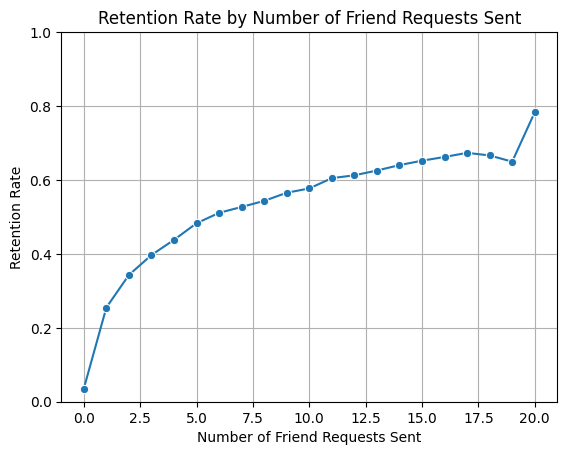

In [18]:
# friend_requests_sent 범주화 (예: 0~10까지만 표시)
user_df['friend_sent_bin'] = user_df['friend_requests_sent'].clip(upper=20)

# 평균 잔존율 계산
bin_retention = user_df.groupby('friend_sent_bin')['retained'].mean().reset_index()

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=bin_retention, x='friend_sent_bin', y='retained', marker='o')
plt.title('Retention Rate by Number of Friend Requests Sent')  # 보낸 친구 요청 수에 따른 잔존율
plt.xlabel('Number of Friend Requests Sent')
plt.ylabel('Retention Rate')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# 행동에 따른 결과 변화 확인 -> 친구요청수가 많아질수록 잔존할가능성도 같이 증가하나?

In [19]:
# 가입일 추출
signup_df = user_df[['user_id', 'created_at']].rename(columns={'created_at': 'signup_time'})
signup_df['signup_time'] = pd.to_datetime(signup_df['signup_time'])

# 친구요청 데이터 준비
friend_df = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))
friend_df = friend_df.rename(columns={'send_user_id': 'user_id'})
friend_df['created_at'] = pd.to_datetime(friend_df['created_at'])

friend_df = friend_df.merge(signup_df, on='user_id', how='left')
friend_df['hour_diff'] = (friend_df['created_at'] - friend_df['signup_time']).dt.total_seconds() / 3600

# 첫날 요청 수 계산
friend_day1_df = friend_df[friend_df['hour_diff'] <= 24]
friend_day1_counts = friend_day1_df.groupby('user_id').size().reset_index(name='friend_requests_day1')
user_df = user_df.merge(friend_day1_counts, on='user_id', how='left')
user_df['friend_requests_day1'] = user_df['friend_requests_day1'].fillna(0)

# 잔존 여부 병합
user_df = user_df.merge(user_survival[['user_id', 'is_churn']], on='user_id', how='left')
user_df['retained'] = user_df['is_churn'].apply(lambda x: 0 if x == 1 else 1)



: 

: 

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = user_df[user_df['friend_requests_day1'] <= 20]

sns.kdeplot(
    data=subset,
    x='friend_requests_day1',
    hue='retained',
    common_norm=False,
    fill=True
)

plt.title('Distribution of Friend Requests on Signup Day by Retention')
plt.xlabel('Friend Requests Sent on Signup Day')
plt.ylabel('Density')
plt.legend(title='Retained', labels=['Churned (0)', 'Retained (1)'])
plt.grid(True)
plt.show()


# 가설: 가입 초기 친구 수와 사용자 잔존 간의 관계

> **"가입 초기 친구 수가 많을수록 사용자가 서비스를 지속적으로 이용할 가능성이 높다"**

→ 초기에 친구관계의 형성이 사용자 잔존에 긍정적 영향을 준다.

---

## 📊 사용 분석 방법

- **점이연 상관분석**  
  → 친구 요청 수(연속형)와 잔존 여부(이진형) 간 상관관계 계산

- **카이제곱 검정**  
  → 친구 수 범주(`none`, `few`, `some`, `many`)에 따라 잔존율 차이 검정

- **로지스틱 회귀**  
  → 친구 요청 수가 잔존 확률에 미치는 영향을 추정 (예측모델 기반)

---

## ✅ 분석 결과

### 1. 점이연 상관분석
- 상관계수: **0.256**, *p* < 0.001  
- 친구 요청 수가 많을수록 잔존할 가능성이 유의미하게 **양의 상관**을 보임  
- 다만, 상관계수의 크기는 **중간 이하 수준**

---

### 2. 카이제곱 독립성 검정

| 친구 수 범주      | 이탈자 수 | 잔존자 수 | 잔존율   |
|------------------|-----------|-----------|----------|
| none (0명)       | 27,012    | 1,001     | **3.6%** |
| few (1~2명)      | 17,652    | 7,472     | **29.7%** |
| some (3~5명)     | 22,786    | 17,978    | **44.1%** |
| many (6명 이상)  | 168,006   | 415,178   | **71.2%** |

- Chi² = **78,061**, *p* < 0.001  
- 친구 수에 따라 **잔존율에 매우 유의미한 차이** 존재  
- 특히 친구가 없는 경우 잔존율이 매우 낮고, 친구 수가 많아질수록 지속 이용률이 급격히 증가함

---

### 3. 로지스틱 회귀 분석

- 회귀식: `retained ~ friend_requests_sent`
- 친구 요청 수가 1건 증가할 때마다 **잔존 확률이 약 1.039배 증가**
- 계수: **0.0383**, *p* < 0.001  
- **Odds Ratio = 1.039**, **Pseudo R² = 0.073**
- 설명력은 낮지만, 친구 수는 잔존에 유의한 예측 변수로 작용함

---

## 🧩 해석 및 결론

- 가입 초기 친구 요청 활동이 많을수록 사용자가 **지속적으로 서비스에 머물 가능성이 유의하게 높음**
- 친구가 **0명인 유저는 잔존율이 극단적으로 낮음(3.6%)**
- 친구 수가 많을수록 잔존율이 증가하는 경향은 **"초기 네트워크 형성"이 잔존에 핵심 역할을 할 수 있음**을 시사




In [ ]:
# 데이터 로딩 및 전처리
import pandas as pd
import os

# 경로 설정
data_dir = '/home/jovyan/work/data'

# 유저 정보 (잔존 여부 포함)
user_df = pd.read_csv(os.path.join(data_dir, 'accounts_user_processed.csv'))
user_df = user_df.rename(columns={'id': 'user_id'})

# 친구 요청 정보
friend_df = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))
